# Voxel-wise multivariate analysis
This notebook presents the process to voxel-wise multivariate analysis performed with conductivity ($\sigma$) maps as response variable and postmenstrual age (PMA), preterm birth (PTB), relative ventricle volume (RVV) scalars and mean diffusivity (MD) images as predictors. We also included additional local volume change (LVC) maps as predictor which were calculated using a tensor-based morphometry (TBM) technique. We excluded sessions of preterm infants scanned before the 37 week threshold to account for prematurity. In total, $n = 614$ neonates were included in this analysis.
 
Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.mask import *
from utils.tools import *
from utils.epglm import *
from utils.plots import *

## 1. Image pre-processing
All images ($\sigma$, MD and LVC) were downsampled to $1.5$ mm isotropic resolution to reduce computation time and the brain ROI was eroded by $4.8$ mm to remove boundary artefacts present in $\sigma$ maps. $\sigma$, MD and LVC were downsampled in the processing notebooks.

In [2]:
# Set directories
atlas_dir = os.path.join(base_dir, "data", "dHCP", "atlas", "anat")
glm_dir = os.path.join(base_dir, "data", "dHCP", "glm")

# Set file path
mask_path = os.path.join(atlas_dir, "week40_mask.nii.gz")
eroded_mask_path = os.path.join(glm_dir, "week40_mask_eroded.nii.gz")
mask_glm_path = os.path.join(glm_dir, "week40_mask_eroded_res15mm.nii.gz")

# Apply erosion
erode_mask(
    input_mask_path=mask_path,
    output_mask_path=eroded_mask_path,
    erosion_radius=4.8,
    erosion_shape="ball",
)

# Resample to 1.5 mm
mirtk_resample_image(
    input_path=eroded_mask_path,
    output_path=mask_glm_path,
    size=[1.5, 1.5, 1.5],
    interp="NN with padding",
)

## 2. General linear model (GLM)
We performed multivariate voxel-wise linear regression using the method based on nonparametric permutation inference for general linear model implemented in FSL (**randomise**). The response variable of the linear model corresponded to the $\sigma$ maps reconstructed from dHCP TSE scans which were non-linearly registered to the 40 week template space using the available neonatal diffeomorphisms. Furthermore, voxel-wise statistical analysis allows us to account for local structural and morphometric changes in brain anatomy during neonatal development. To this end, we used a tensor-based morphometry (TBM) approach, which calculates the logarithm of the Jacobian determinant of the diffeomorphisms from subject space to the week by week template space as an indicator of local volume change (LVC). The Jacobians were subsequently warped to the 40 week template and smoothed by an isotropic Gaussian filter with 3 voxels STD kernel. In addition, MD images were also non-linearly registered to the 40 week template space using the same neonatal diffeomorphism. The predictor variables included in the multivariate model can thus be categorised as either scalar (PMA, PTB and RVV) or voxel-wise (MD and LVC). 

We tested for positive and negative interactions between $\sigma$ and each explanatory variable independently. The Bonferroni correction was applied to adjust the $0.05$ significance level for two-way comparisons. The permutation inference method for general linear model was applied with $n = 10 000$ permutations. The significance *t*-statistics maps were corrected for family-wise error (FWE) arising from multiple hypothesis testing and we used threshold free cluster enhancement (TFCE) as post-processing. The significance maps were thresholded at the $0.05$ significance level for visualisation purposes.

In [3]:
# Dummy explanatory variables
ep_paths = [os.path.join(base_dir, "data", "dHCP", "example_subject", "TSE", "derivatives_pocr", "sig_in_extdhcp40wk_res15mm.nii.gz")]
ev_path = os.path.join(glm_dir, "EV.json")
vox_ev_path = os.path.join(glm_dir, "vox_EV.json")

# Run GLM
ep_glm(
    input_ep_paths=ep_paths,
    input_mask_path=eroded_mask_path,
    output_dir=glm_dir,
    input_ev_path=ev_path,
    input_vox_ev_path=vox_ev_path,
    n_perm=10000,
    alpha=0.05,
)

## 3. Significance maps visualisation
Significance maps were resampled to 0.5 mm for visualization purposes.

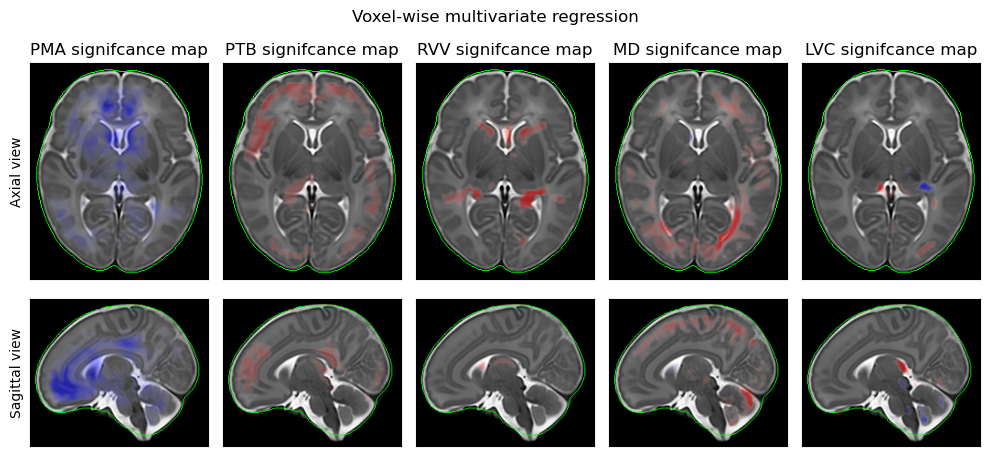

In [4]:
# Set file path
plot_path = os.path.join(base_dir, "plots", "experiments", "dhcp_glm.png")
anat_atlas_path = os.path.join(atlas_dir, "week40_T2w.nii.gz")
ev_map_paths = []

# Labels
ev_labels = ["PMA", "PTB", "RVV", "MD", "LVC"]

# Iter over explanatory variable
for ev in ev_labels:
    # Set file path
    ev_dir = os.path.join(glm_dir, ev)
    tstat_path = os.path.join(ev_dir, f"{ev}_tstat_thresh_tfce_corrp.nii.gz")
    tstat_res05mm_path = os.path.join(ev_dir, f"{ev}_tstat_thresh_tfce_corrp_res05mm.nii.gz")
    
    # Sample back to 0.5mm for visualization
    mirtk_transform_image(
        input_path=tstat_path,
        output_path=tstat_res05mm_path,
        input_target_path=anat_atlas_path,
    )
    
    ev_map_paths += [tstat_res05mm_path]

# Plotting
dhcp_glm_plot(
    input_anat_atlas_path=anat_atlas_path,
    input_ev_map_paths=ev_map_paths,
    input_ev_labels=ev_labels,
    input_mask_path=eroded_mask_path,
    output_plot_path=plot_path,
    figsize=(10, 5),
    view_info={"axial": { "slice_index": 98}, "sagittal": {"slice_index": 107}},
    mag_clim=[0.0, 95.0],
    alpha=0.5,
    ev_cmap="bwr",
    outline_c=(0,1,0),
    ev_clim={"PMA": [-10, 10], "PTB": [-6.5, 6.5], "MD": [-6.5, 6.5], "RVV": [-5, 5], "LVC": [-4.5, 4.5]},
    title="Voxel-wise multivariate regression",
    save_imageio=True,
)

Significance maps highlight voxels in which there are significant $\sigma$-PMA and $\sigma$-PTB associations that persist following correction for the decline in local water content and morphological changes. From a general perspective, the voxel-level associations are consistent with previous whole-brain $\sigma$ results, exhibiting negative linear $\sigma$-PMA effect and a positive $\sigma$-PTB relationship. We observed that PMA related negative correlation was largely concentrated in the frontal white matter, while positive association with PTB was distributed more peripherally.